In [267]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
%matplotlib inline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score
import pickle
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.dummy import DummyClassifier

In [268]:
#Load Data

In [269]:
df = pd.read_csv('./data/dataset.csv')

In [270]:
#Look at the data

In [271]:
df.head()

,encounter_id,patient_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,icu_admit_source,...,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem,Unnamed: 83,hospital_death
0,66154,25312,118,68.0,22.73,0,Caucasian,M,180.3,Floor,...,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular,NaN,0
1,114252,59342,81,77.0,27.42,0,Caucasian,F,160.0,Floor,...,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory,NaN,0
2,119783,50777,118,25.0,31.95,0,Caucasian,F,172.7,Accident & Emergency,...,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic,NaN,0
3,79267,46918,118,81.0,22.64,1,Caucasian,F,165.1,Operating Room / Recovery,...,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular,NaN,0
4,92056,34377,33,19.0,NaN,0,Caucasian,M,188.0,Accident & Emergency,...,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma,NaN,0


In [272]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91713 entries, 0 to 91712
Data columns (total 85 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   encounter_id                   91713 non-null  int64  
 1   patient_id                     91713 non-null  int64  
 2   hospital_id                    91713 non-null  int64  
 3   age                            87485 non-null  float64
 4   bmi                            88284 non-null  float64
 5   elective_surgery               91713 non-null  int64  
 6   ethnicity                      90318 non-null  object 
 7   gender                         91688 non-null  object 
 8   height                         90379 non-null  float64
 9   icu_admit_source               91601 non-null  object 
 10  icu_id                         91713 non-null  int64  
 11  icu_stay_type                  91713 non-null  object 
 12  icu_type                       91713 non-null 

In [273]:
# Checking for class imbalance 

In [274]:
df.hospital_death.value_counts(normalize=True)

0    0.913698
1    0.086302
Name: hospital_death, dtype: float64

## Cleaning

In [275]:
# Drop unnamed and empty column

In [276]:
df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis =1,inplace=True)

In [277]:
# Drop unique Identifier columns

In [278]:
df.drop(df.columns[df.columns.str.contains('_id',case = False)],axis =1,inplace=True)

In [279]:
df.info() # sanity check

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91713 entries, 0 to 91712
Data columns (total 80 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            87485 non-null  float64
 1   bmi                            88284 non-null  float64
 2   elective_surgery               91713 non-null  int64  
 3   ethnicity                      90318 non-null  object 
 4   gender                         91688 non-null  object 
 5   height                         90379 non-null  float64
 6   icu_admit_source               91601 non-null  object 
 7   icu_stay_type                  91713 non-null  object 
 8   icu_type                       91713 non-null  object 
 9   pre_icu_los_days               91713 non-null  float64
 10  weight                         88993 non-null  float64
 11  apache_2_diagnosis             90051 non-null  float64
 12  apache_3j_diagnosis            90612 non-null 

Dictionary from Daniel Warda,
https://www.kaggle.com/code/danielwarda/patient-survival-prediction-eda-part-1/notebook

In [280]:
dict_description={'encounter_id' : 'Unique identifier associated with a patient unit stay',
'patient_id': 'Unique identifier associated with a patient',
'hospital_id': 'Unique identifier associated with a hospital',
'age': 'The age of the patient on unit admission',
'bmi': 'The body mass index of the person on unit admission',
'elective_surgery':'Whether the patient was admitted to the hospital for an elective surgical operation',
'ethnicity':'The common national or cultural tradition which the person belongs to',
'gender':'Sex of the patient',
'height':'The height of the person on unit admission',
'icu_admit_source':'The location of the patient prior to being admitted to the unit',
'icu_id':' unique identifier for the unit to which the patient was admitted',
'icu_stay_type':'string',
'icu_type': 'A classification which indicates the type of care the unit is capable of providing',               
'pre_icu_los_days': 'The length of stay of the patient between hospital admission and unit admission',
'weight' :'The weight (body mass) of the person on unit admission',
'apache_2_diagnosis' :'The APACHE II diagnosis for the ICU admission',
'apache_3j_diagnosis' :'The APACHE III-J sub-diagnosis code which best describes the reason for the ICU admission',
'apache_post_operative':'The APACHE operative status; 1 for post-operative, 0 for non-operative',
'arf_apache':' Whether the patient had acute renal failure during the first 24 hours of their unit stay, defined as a 24 hour urine output <410ml, creatinine >=133 micromol/L and no chronic dialysis',
'gcs_eyes_apache':'The eye opening component of the Glasgow Coma Scale measured during the first 24 hours which results in the highest APACHE III score',
'gcs_motor_apache': 'The motor component of the Glasgow Coma Scale measured during the first 24 hours which results in the highest APACHE III score',
'gcs_unable_apache': 'Whether the Glasgow Coma Scale was unable to be assessed due to patient sedation',
 'gcs_verbal_apache': 'The verbal component of the Glasgow Coma Scale measured during the first 24 hours which results in the highest APACHE III score',
'heart_rate_apache': 'The heart rate measured during the first 24 hours which results in the highest APACHE III score',
'intubated_apache': 'Whether the patient was intubated at the time of the highest scoring arterial blood gas used in the oxygenation score',
'map_apache': 'The mean arterial pressure measured during the first 24 hours which results in the highest APACHE III score',
'resprate_apache': 'The respiratory rate measured during the first 24 hours which results in the highest APACHE III score',
'temp_apache': 'The temperature measured during the first 24 hours which results in the highest APACHE III score',
'ventilated_apache': 'Whether the patient was invasively ventilated at the time of the highest scoring arterial blood gas using the oxygenation scoring algorithm, including any mode of positive pressure ventilation delivered through a circuit attached to an endo-tracheal tube or tracheostomy',      
'd1_diasbp_max':"The patient's highest diastolic blood pressure during the first 24 hours of their unit stay, either non-invasively or invasively measured",
'd1_diasbp_min':"The patient's lowest diastolic blood pressure during the first 24 hours of their unit stay, either non-invasively or invasively measured",
'd1_diasbp_noninvasive_max':"The patient's highest diastolic blood pressure during the first 24 hours of their unit stay, non-invasively measured",
'd1_diasbp_noninvasive_min':"The patient's lowest diastolic blood pressure during the first 24 hours of their unit stay, non-invasively measured",
'd1_heartrate_max':"The patient's highest heart rate during the first 24 hours of their unit stay",
'd1_heartrate_min':"The patient's lowest heart rate during the first 24 hours of their unit stay",
'd1_mbp_max':"The patient's highest mean blood pressure during the first 24 hours of their unit stay, either non-invasively or invasively measured",
'd1_mbp_min':"The patient's lowest mean blood pressure during the first 24 hours of their unit stay, either non-invasively or invasively measured",
'd1_mbp_noninvasive_max':"The patient's highest mean blood pressure during the first 24 hours of their unit stay, non-invasively measured",
'd1_mbp_noninvasive_min':"The patient's lowest mean blood pressure during the first 24 hours of their unit stay, non-invasively measured",
'd1_resprate_max':"The patient's highest respiratory rate during the first 24 hours of their unit stay",
'd1_resprate_min':"The patient's lowest respiratory rate during the first 24 hours of their unit stay",
'd1_spo2_max':"The patient's highest peripheral oxygen saturation during the first 24 hours of their unit stay",
'd1_spo2_min':"The patient's lowest peripheral oxygen saturation during the first 24 hours of their unit stay",
'd1_sysbp_max':"The patient's highest systolic blood pressure :uring the first 24 hours of their unit stay, either non-invasively or invasively measured",
'd1_sysbp_min':"The patient's lowest systolic blood pressure :uring the first 24 hours of their unit stay, either non-invasively or invasively measured",
'd1_sysbp_noninvasive_max':"The patient': highest systolic blood pressure during the first 24 hours of their unit stay, invasively measured",
'd1_sysbp_noninvasive_min':"The patient': lowest systolic blood pressure during the first 24 hours of their unit stay, invasively measured",
'd1_temp_max':"The patient:s highest core temperature during the first 24 hours of their unit stay, invasively measured",
'd1_temp_min':"The patient's lowest core temperature during the first 24 hours of their unit stay",
'h1_diasbp_max':"The patient's highest diastolic blood :ressure during the first hour of their unit stay, either non-invasively or invasively measured",
'h1_diasbp_min':"The patient's lowest diastolic blood :ressure during the first hour of their unit stay, either non-invasively or invasively measured",
'h1_diasbp_noninvasive_max':"The patient:s highest diastolic blood pressure during the first hour of their unit stay, invasively measured",
'h1_diasbp_noninvasive_min':"The patient:s lowest diastolic blood pressure during the first hour of their unit stay, invasively measured",
'h1_heartrate_max':"The patient's highest heart rate during the first hour of their unit stay",
'h1_heartrate_min':"The patient's lowest heart rate during the first hour of their unit stay",
'h1_mbp_max':"The patient's highest mean blood :ressure during the first hour of their unit stay, either non-invasively or invasively measured",
'h1_mbp_min':"The patient's lowest mean blood :ressure during the first hour of their unit stay, either non-invasively or invasively measured",
'h1_mbp_noninvasive_max':"The patient's :ighest mean blood pressure during the first hour of their unit stay, non-invasively measured",
'h1_mbp_noninvasive_min':"The patient's :owest mean blood pressure during the first hour of their unit stay, non-invasively measured",
'h1_resprate_max':"The patient's highest respiratory rate during the first hour of their unit stay",
'h1_resprate_min':"The patient's lowest respiratory rate during the first hour of their unit stay",
'h1_spo2_max':"The patient's highest peripheral oxygen saturation during the first hour of their unit stay",
'h1_spo2_min':"The patient's lowest peripheral oxygen saturation during the first hour of their unit stay",
'h1_sysbp_max':"The patient's highest systolic blood pressure during the first hour of their unit stay, either non-invasively or invasively measured",
'h1_sysbp_min':"The patient's lowest systolic blood pressure during the first hour of their unit stay, either non-invasively or invasively measured",
'h1_sysbp_noninvasive_max':"The patient's highest systolic blood pressure during the first hour of their unit stay, non-invasively measured",
'h1_sysbp_noninvasive_min':"The patient's lowest systolic blood pressure during the first hour of their unit stay, non-invasively measured",
'd1_glucose_max':"The highest glucose concentration of the patient in their serum or plasma during the first 24 hours of their unit stay",
'd1_glucose_min':"The lowest glucose concentration of the patient in their serum or plasma during the first 24 hours of their unit stay",
'd1_potassium_max':"The highest potassium concentration for the patient in their serum or plasma during the first 24 hours of their unit stay",
'd1_potassium_min':"The lowest potassium concentration for the patient in their serum or plasma during the first 24 hours of their unit stay",
'apache_4a_hospital_death_prob':"The APACHE IVa probabilistic prediction of in-hospital mortality for the patient which utilizes the APACHE III score and other covariates, including diagnosis.",
'apache_4a_icu_death_prob':"The APACHE IVa probabilistic prediction of in ICU mortality for the patient which utilizes the APACHE III score and other covariates, including diagnosis",
'aids':"Whether the patient has a definitive diagnosis of acquired immune deficiency syndrome (AIDS) (not HIV positive alone)",
'cirrhosis':"Whether the patient has a history of heavy alcohol use with portal hypertension and varices, other causes of cirrhosis with evidence of portal hypertension and varices, or biopsy proven cirrhosis. This comorbidity does not apply to patients with a functioning liver transplant.",
'diabetes_mellitus':"Whether the patient has been diagnosed with diabetes, either juvenile or adult onset, which requires medication.",
'hepatic_failure':"Whether the patient has cirrhosis and additional complications including jaundice and ascites, upper GI bleeding, hepatic encephalopathy, or coma.",
'immunosuppression':"Whether the patient has their immune system suppressed within six months prior to ICU admission for any of the following reasons; radiation therapy, chemotherapy, use of non-cytotoxic immunosuppressive drugs, high dose steroids (at least 0.3 mg/kg/day of methylprednisolone or equivalent for at least 6 months).",
'leukemia':"Whether the patient has been diagnosed with acute or chronic myelogenous leukemia, acute or chronic lymphocytic leukemia, or multiple myeloma.",
'lymphoma':"Whether the patient has been diagnosed with non-Hodgkin lymphoma.",
'solid_tumor_with_metastasis':"Whether the patient has been diagnosed with any solid tumor carcinoma (including malignant melanoma) which has evidence of metastasis.",
'apache_3j_bodysystem':"Admission diagnosis group for APACHE III",
'apache_2_bodysystem':"Admission diagnosis group for APACHE II",
'hospital_death':"Whether the patient died during this hospitalization"}

In [281]:
# checking nulls in columns

In [282]:
df.isnull().sum()

age                            4228
bmi                            3429
elective_surgery                  0
ethnicity                      1395
gender                           25
                               ... 
lymphoma                        715
solid_tumor_with_metastasis     715
apache_3j_bodysystem           1662
apache_2_bodysystem            1662
hospital_death                    0
Length: 80, dtype: int64

In [283]:
# Creating data frame of rows with null values

In [284]:
null_data = df[df.isnull().any(axis=1)]

In [285]:
null_data.shape

(34778, 80)

In [286]:
# dropping eththnicity column

In [287]:
df.drop('ethnicity',axis =1,inplace=True)

In [288]:
# checking class in df 

In [289]:
df.hospital_death.value_counts(normalize=True)

0    0.913698
1    0.086302
Name: hospital_death, dtype: float64

In [290]:
# check imbalances in null df

In [291]:
null_data.hospital_death.value_counts(normalize=True)

0    0.913048
1    0.086952
Name: hospital_death, dtype: float64

With the class imbalances nearly identicle if the rows of nulls are dropped it won't affect the proportion within the target class.

In [292]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91713 entries, 0 to 91712
Data columns (total 79 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            87485 non-null  float64
 1   bmi                            88284 non-null  float64
 2   elective_surgery               91713 non-null  int64  
 3   gender                         91688 non-null  object 
 4   height                         90379 non-null  float64
 5   icu_admit_source               91601 non-null  object 
 6   icu_stay_type                  91713 non-null  object 
 7   icu_type                       91713 non-null  object 
 8   pre_icu_los_days               91713 non-null  float64
 9   weight                         88993 non-null  float64
 10  apache_2_diagnosis             90051 non-null  float64
 11  apache_3j_diagnosis            90612 non-null  float64
 12  apache_post_operative          91713 non-null 

In [293]:
# collecting column names that are categorical

In [294]:
cat_columns= ['elective_surgery',
              'gender',
              'icu_admit_source',
              'icu_stay_type',
              'icu_type',
              'apache_3j_diagnosis',
              'apache_post_operative',
              'arf_apache',
              'gcs_eyes_apache',
              'gcs_motor_apache',
              'gcs_unable_apache',
              'gcs_verbal_apache',
              'intubated_apache',
              'ventilated_apache',
              'aids',
              'cirrhosis',
              'diabetes_mellitus',
              'hepatic_failure',
              'immunosuppression',
              'leukemia',
              'lymphoma',
              'solid_tumor_with_metastasis',
              'apache_3j_bodysystem',
              'hospital_death']

In [295]:
# Create list of column names 

In [296]:
df_columns = df.columns.tolist()

In [297]:
# creating list of names of numerical columns

In [298]:
num_columns =  [x for x in df_columns if x not in cat_columns] #[i for i in test_list if i not in remove_list]

In [299]:
num_columns

['age',
 'bmi',
 'height',
 'pre_icu_los_days',
 'weight',
 'apache_2_diagnosis',
 'heart_rate_apache',
 'map_apache',
 'resprate_apache',
 'temp_apache',
 'd1_diasbp_max',
 'd1_diasbp_min',
 'd1_diasbp_noninvasive_max',
 'd1_diasbp_noninvasive_min',
 'd1_heartrate_max',
 'd1_heartrate_min',
 'd1_mbp_max',
 'd1_mbp_min',
 'd1_mbp_noninvasive_max',
 'd1_mbp_noninvasive_min',
 'd1_resprate_max',
 'd1_resprate_min',
 'd1_spo2_max',
 'd1_spo2_min',
 'd1_sysbp_max',
 'd1_sysbp_min',
 'd1_sysbp_noninvasive_max',
 'd1_sysbp_noninvasive_min',
 'd1_temp_max',
 'd1_temp_min',
 'h1_diasbp_max',
 'h1_diasbp_min',
 'h1_diasbp_noninvasive_max',
 'h1_diasbp_noninvasive_min',
 'h1_heartrate_max',
 'h1_heartrate_min',
 'h1_mbp_max',
 'h1_mbp_min',
 'h1_mbp_noninvasive_max',
 'h1_mbp_noninvasive_min',
 'h1_resprate_max',
 'h1_resprate_min',
 'h1_spo2_max',
 'h1_spo2_min',
 'h1_sysbp_max',
 'h1_sysbp_min',
 'h1_sysbp_noninvasive_max',
 'h1_sysbp_noninvasive_min',
 'd1_glucose_max',
 'd1_glucose_min',
 'd

In [300]:
# Dropping null rows

In [301]:
df_clean = df.dropna() 

In [302]:
# Dropping APACHE 2 because APACHE 3 is a more updated version 

In [303]:
df_clean.drop(['apache_2_diagnosis','apache_2_bodysystem'],axis = 1,inplace=True)

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [304]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57544 entries, 0 to 91712
Data columns (total 77 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            57544 non-null  float64
 1   bmi                            57544 non-null  float64
 2   elective_surgery               57544 non-null  int64  
 3   gender                         57544 non-null  object 
 4   height                         57544 non-null  float64
 5   icu_admit_source               57544 non-null  object 
 6   icu_stay_type                  57544 non-null  object 
 7   icu_type                       57544 non-null  object 
 8   pre_icu_los_days               57544 non-null  float64
 9   weight                         57544 non-null  float64
 10  apache_3j_diagnosis            57544 non-null  float64
 11  apache_post_operative          57544 non-null  int64  
 12  arf_apache                     57544 non-null 

In [305]:
num_columns.remove('apache_2_diagnosis')
num_columns.remove('apache_2_bodysystem')

In [306]:
numeric_df = df_clean[num_columns]

In [307]:
numeric_df.shape

(57544, 53)

In [308]:
# Visualize numerical columns

In [309]:
unpivot = pd.melt(numeric_df, numeric_df.describe().columns[0], numeric_df.describe().columns[1:])

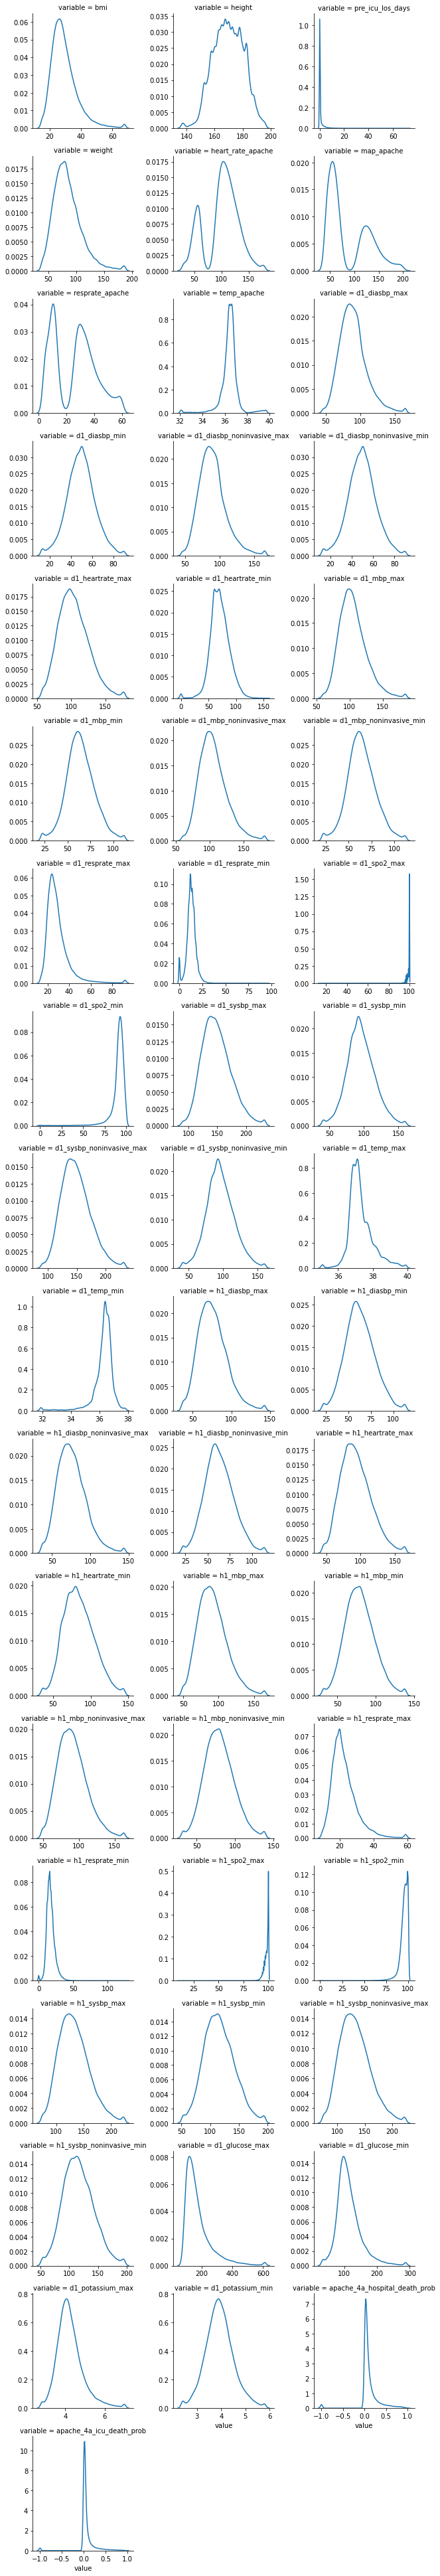

In [310]:
fig1 = sns.FacetGrid(unpivot, col = 'variable', col_wrap = 3,
                    sharex = False, sharey = False)
fig1.map(sns.kdeplot, "value")
plt.show()

In [311]:
# Remove death probabilities with values less than zero

In [312]:
df_clean = df_clean[(df_clean['apache_4a_hospital_death_prob']>=0) & (df_clean['apache_4a_icu_death_prob']>=0)]

In [313]:
# creating dataframe for categorical variables 

In [314]:
cat_df = df_clean[cat_columns]

In [315]:
# Look at categories to be OneHotEncoded

In [316]:
cat_df.icu_admit_source.value_counts()

Accident & Emergency         34626
Operating Room / Recovery    10248
Floor                         9850
Other Hospital                1689
Other ICU                       81
Name: icu_admit_source, dtype: int64

In [317]:
cat_df.icu_stay_type.value_counts()

admit       52957
transfer     3453
readmit        84
Name: icu_stay_type, dtype: int64

In [318]:
cat_df_apache = cat_df.apache_3j_diagnosis.value_counts().to_frame()
cat_df_apache[cat_df_apache['apache_3j_diagnosis']==1]

,apache_3j_diagnosis
1202.01,1
1408.11,1
1304.03,1
1101.05,1
1101.02,1
1604.04,1
901.07,1
1604.02,1
1604.01,1
408.03,1


In [319]:
cat_df.apache_3j_bodysystem.value_counts()

Cardiovascular          17189
Sepsis                   8210
Respiratory              7537
Neurological             7457
Gastrointestinal         5923
Metabolic                5129
Trauma                   2397
Genitourinary            1393
Musculoskeletal/Skin      674
Hematological             427
Gynecological             158
Name: apache_3j_bodysystem, dtype: int64

In [320]:
# Train-test split

X = df_clean.drop('hospital_death',axis =1)
y = df_clean.hospital_death
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)

In [321]:
# creating numerical and categorical piplines

In [322]:
subpipe_num = Pipeline(steps=[('ss', StandardScaler())])
                              
subpipe_cat = Pipeline(steps=[('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))])
                                                            

In [323]:
# creating column transformer

In [324]:
ct = ColumnTransformer(transformers=[
    ('subpipe_num', subpipe_num, num_columns),
    ('subpipe_cat', subpipe_cat, [3,5,6,7,10,75])
],remainder='passthrough')

In [325]:
pd.DataFrame(ct.fit_transform(X_train))

,0,1,2,3,4,5,6,7,8,9,...,461,462,463,464,465,466,467,468,469,470
0,-1.294613,-0.590808,-0.168721,-0.284364,-0.623946,0.874890,-0.896088,0.256745,0.447923,0.225138,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.267945,0.870446,0.505586,-0.140531,1.105828,0.228492,-0.942980,0.784011,-0.375692,-1.101726,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.573433,-1.726964,1.447386,0.555516,-1.319051,1.585928,-0.591291,0.388561,-0.140373,1.500968,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,-0.934023,-0.982078,-0.679560,-0.276658,-1.143277,0.131532,-0.239601,-0.072797,0.212605,0.021005,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.393137,-0.948933,-0.911759,-0.163932,-1.183226,-1.710703,1.401616,0.586286,-0.140373,2.725766,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42365,1.469913,0.173122,0.267814,2.569457,0.286882,-0.159347,-0.896088,-1.127330,-0.140373,-1.407926,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
42366,-0.813826,-0.395861,1.131595,-0.287218,0.067165,-1.872302,0.792021,-0.797788,0.353796,0.684437,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42367,-0.633531,0.615526,-0.670272,-0.246123,0.258918,-1.839983,1.776751,0.784011,0.330264,0.582370,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42368,0.207847,-1.404148,-0.447361,-0.284364,-1.454876,0.551691,-0.474061,0.322653,0.212605,-0.336228,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [326]:
X_train.head()

,age,bmi,elective_surgery,gender,height,icu_admit_source,icu_stay_type,icu_type,pre_icu_los_days,weight,...,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem
24500,41.0,24.376417,0,F,168.00,Accident & Emergency,admit,Med-Surg ICU,0.131944,68.8,...,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic
34062,67.0,36.495557,0,M,175.26,Accident & Emergency,admit,Cardiac ICU,0.481944,112.1,...,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sepsis
33479,53.0,14.953528,0,M,185.40,Floor,admit,Med-Surg ICU,2.175694,51.4,...,0.02,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,Cardiovascular
30371,47.0,21.131361,0,F,162.50,Accident & Emergency,admit,CSICU,0.150694,55.8,...,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic
46665,56.0,21.406250,0,F,160.00,Floor,admit,SICU,0.425000,54.8,...,0.03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neurological


## Modeling

In [327]:
from sklearn.model_selection import cross_val_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix, f1_score, roc_auc_score, plot_roc_curve


class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''

    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()

    def cross_validate(self, X=None, y=None, kfolds=5):
        '''
        Perform cross-validation and return results.
        Args:
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)
        '''

        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

#     def print_cv_summary(self):
#         cv_summary = (
#             f'''CV Results for `{self.name}` model:
#             {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
#         ''')
#         print(cv_summary)

    def plot_cv(self, ax):
        '''
        Plot the cross-validation values using the array of results and given
        Axis for plotting.
        '''
        ax.set_title(f'CV Results for `{self.name}` Model')
        # Thinner violinplot with higher bw
        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
            y=self.cv_results,
            color='orange',
            size=10,
            alpha=0.8,
            ax=ax
        )

        return ax

    def print_summary(self):
        roc = plot_roc_curve(self.model, self.X , self.y);
        cm = plot_confusion_matrix(self.model, self.X, self.y);
        preds = self.model.predict(self.X)
        f1_ = f1_score(self.y, preds)
        cv_summary = (
            f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
        ''')

        print(f' \n  f1_score is {f1_}', cv_summary ,cm, roc)      

In [328]:
#Dummy model

In [329]:
imb_dummy_pipe = imbPipeline(steps=[('ct', ct),
                             ('sm', SMOTE(random_state=42)),
                             ('dummy',DummyClassifier())
                             ],verbose=True)

In [330]:
imb_dummy_pipe.fit(X_train,y_train)

[Pipeline] ................ (step 1 of 3) Processing ct, total=   0.1s
[Pipeline] ................ (step 2 of 3) Processing sm, total=   0.5s
[Pipeline] ............. (step 3 of 3) Processing dummy, total=   0.0s


Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  ['age', 'bmi', 'height',
                                                   'pre_icu_los_days', 'weight',
                                                   'heart_rate_apache',
                                                   'map_apache',
                                                   'resprate_apache',
                                                   'temp_apache',
                                                   'd1_diasbp_max',
                                                   'd1_diasbp_min',
                                                   'd1_diasbp_noninvasive_max',
                                              

In [331]:
imb_dummy_pipe.score(X_train,y_train)

0.9132168987491149

In [332]:
rf_dummy_pipe = ModelWithCV(imb_dummy_pipe,model_name='rf_dummy_pipe',X=X_train,y=y_train)

[Pipeline] ................ (step 1 of 3) Processing ct, total=   0.1s
[Pipeline] ................ (step 2 of 3) Processing sm, total=   0.2s
[Pipeline] ............. (step 3 of 3) Processing dummy, total=   0.0s
[Pipeline] ................ (step 1 of 3) Processing ct, total=   0.1s
[Pipeline] ................ (step 2 of 3) Processing sm, total=   0.2s
[Pipeline] ............. (step 3 of 3) Processing dummy, total=   0.0s
[Pipeline] ................ (step 1 of 3) Processing ct, total=   0.1s
[Pipeline] ................ (step 2 of 3) Processing sm, total=   0.2s
[Pipeline] ............. (step 3 of 3) Processing dummy, total=   0.0s
[Pipeline] ................ (step 1 of 3) Processing ct, total=   0.1s
[Pipeline] ................ (step 2 of 3) Processing sm, total=   0.2s
[Pipeline] ............. (step 3 of 3) Processing dummy, total=   0.0s
[Pipeline] ................ (step 1 of 3) Processing ct, total=   0.1s
[Pipeline] ................ (step 2 of 3) Processing sm, total=   0.2s
[Pipel

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


 
  f1_score is 0.0 CV Results for `rf_dummy_pipe` model:
            0.91322 ± 0.00006 accuracy
         <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay object at 0x7f941e3f16a0> <sklearn.metrics._plot.roc_curve.RocCurveDisplay object at 0x7f9688403eb0>


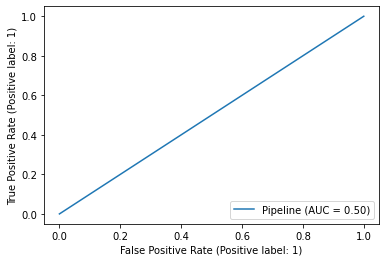

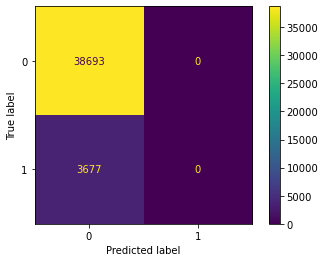

In [333]:
rf_dummy_pipe.print_summary()

In [334]:
# Simple Model

A random forest methodology was chosen because I have a large data set with high dimensionality. Smote was used to deal with the class imbalance of the target. The score I will be focusing on is the F1 score because I care about both precision and recall.

In [335]:
imb_pipe = imbPipeline(steps=[('ct', ct),
                             ('sm', SMOTE()),
                             ('rf', RandomForestClassifier(max_depth=20,verbose=3))
                             ],verbose=True)

In [336]:
imb_pipe.fit(X_train,y_train)

[Pipeline] ................ (step 1 of 3) Processing ct, total=   0.1s
[Pipeline] ................ (step 2 of 3) Processing sm, total=   0.3s
building tree 1 of 100


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s


building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 10

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   17.2s finished


Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  ['age', 'bmi', 'height',
                                                   'pre_icu_los_days', 'weight',
                                                   'heart_rate_apache',
                                                   'map_apache',
                                                   'resprate_apache',
                                                   'temp_apache',
                                                   'd1_diasbp_max',
                                                   'd1_diasbp_min',
                                                   'd1_diasbp_noninvasive_max',
                                              

In [337]:
rf_pipe = ModelWithCV(imb_pipe,model_name='rf_pipe',X=X_train,y=y_train)

[Pipeline] ................ (step 1 of 3) Processing ct, total=   0.1s
[Pipeline] ................ (step 2 of 3) Processing sm, total=   0.2s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


building tree 1 of 100
building tree 2 of 100


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s


building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   13.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


[Pipeline] ................ (step 3 of 3) Processing rf, total=  13.4s
[Pipeline] ................ (step 1 of 3) Processing ct, total=   0.1s
[Pipeline] ................ (step 2 of 3) Processing sm, total=   0.2s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


building tree 1 of 100
building tree 2 of 100


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s


building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   13.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


[Pipeline] ................ (step 3 of 3) Processing rf, total=  13.2s
[Pipeline] ................ (step 1 of 3) Processing ct, total=   0.1s
[Pipeline] ................ (step 2 of 3) Processing sm, total=   0.2s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


building tree 1 of 100
building tree 2 of 100


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s


building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   13.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


[Pipeline] ................ (step 3 of 3) Processing rf, total=  13.2s
[Pipeline] ................ (step 1 of 3) Processing ct, total=   0.1s
[Pipeline] ................ (step 2 of 3) Processing sm, total=   0.2s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


building tree 1 of 100
building tree 2 of 100


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s


building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   13.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


[Pipeline] ................ (step 3 of 3) Processing rf, total=  13.6s
[Pipeline] ................ (step 1 of 3) Processing ct, total=   0.1s
[Pipeline] ................ (step 2 of 3) Processing sm, total=   0.2s
building tree 1 of 100
building tree 2 of 100


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s


building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   13.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.7s finished
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionM

 
  f1_score is 0.9724550898203593 CV Results for `rf_pipe` model:
            0.90930 ± 0.00362 accuracy
         <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay object at 0x7f9438d62a30> <sklearn.metrics._plot.roc_curve.RocCurveDisplay object at 0x7f9438d771c0>


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.6s finished


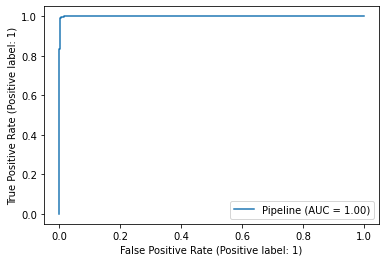

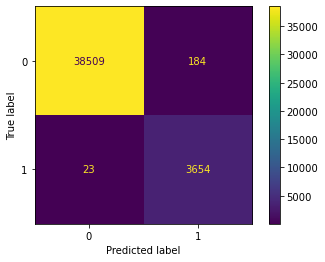

In [338]:
rf_pipe.print_summary()

Model is overfit and needs to be improved.

In [339]:
# Complex Model 

Knowing the previous model was overfit I decreased the max depth and decreased the sampling strategy of the SMOTE and reduce the number of nearest neighbors to 3.

In [340]:
imb_pipe2 = imbPipeline(steps=[('ct', ct),
                             ('sm', SMOTE(sampling_strategy=.25,k_neighbors=3)),
                             ('rf', RandomForestClassifier(max_depth=15,
                                                           criterion='entropy',
                                                           max_features=None,
                                                           n_jobs=-1,
                                                           verbose=2)),
                            ],verbose=True)

In [341]:
imb_pipe2.fit(X_train,y_train)

[Pipeline] ................ (step 1 of 3) Processing ct, total=   0.1s
[Pipeline] ................ (step 2 of 3) Processing sm, total=   0.3s
building tree 1 of 100building tree 2 of 100
building tree 3 of 100

building tree 4 of 100building tree 5 of 100
building tree 6 of 100

building tree 7 of 100
building tree 8 of 100building tree 9 of 100building tree 10 of 100




[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.


building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100building tree 16 of 100

building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100building tree 28 of 100

building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    5.5s


building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100building tree 64 of 100

building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   19.5s finished


Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  ['age', 'bmi', 'height',
                                                   'pre_icu_los_days', 'weight',
                                                   'heart_rate_apache',
                                                   'map_apache',
                                                   'resprate_apache',
                                                   'temp_apache',
                                                   'd1_diasbp_max',
                                                   'd1_diasbp_min',
                                                   'd1_diasbp_noninvasive_max',
                                              

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnin

 
  f1_score is 0.8221015649952091 CV Results for `rf_pipe2` model:
            0.92261 ± 0.00266 accuracy
         <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay object at 0x7f941906b670> <sklearn.metrics._plot.roc_curve.RocCurveDisplay object at 0x7f941d877e80>


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished


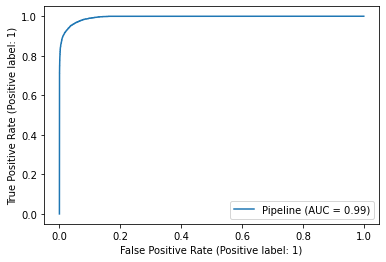

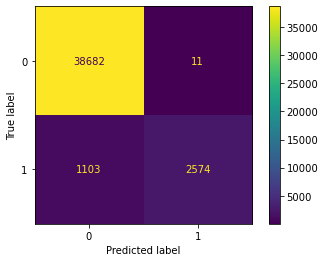

In [342]:
rf_pipe2.print_summary()

In [343]:
# Looks better. Time to check the test data.

In [344]:
f1_score(y_test,imb_pipe2.predict(X_test))

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.0s finished


0.4308717379233759

This model is way over fit with the test data. The model complexity need to be reduced again. The next model will be an Extra tree Classifier because adding more randomness should help.

In [345]:
# More Complex Model

In [346]:
imb_pipe3 = imbPipeline(steps=[('ct', ct),
                             ('sm', SMOTE(sampling_strategy='auto',k_neighbors=10)),
                             ('et', ExtraTreesClassifier(max_depth=10,
                                                         criterion='entropy',
                                                         bootstrap=True,
                                                         
                                                         max_features=None,
                                                         n_jobs=-1,))
                            ],verbose=True)

In [347]:
imb_pipe3.fit(X_train,y_train)

[Pipeline] ................ (step 1 of 3) Processing ct, total=   0.1s
[Pipeline] ................ (step 2 of 3) Processing sm, total=   0.3s
[Pipeline] ................ (step 3 of 3) Processing et, total=  16.0s


Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  ['age', 'bmi', 'height',
                                                   'pre_icu_los_days', 'weight',
                                                   'heart_rate_apache',
                                                   'map_apache',
                                                   'resprate_apache',
                                                   'temp_apache',
                                                   'd1_diasbp_max',
                                                   'd1_diasbp_min',
                                                   'd1_diasbp_noninvasive_max',
                                              

In [348]:
rf_pipe3 = ModelWithCV(imb_pipe3,model_name='rf_pipe3',X=X_train,y=y_train)

[Pipeline] ................ (step 1 of 3) Processing ct, total=   0.1s
[Pipeline] ................ (step 2 of 3) Processing sm, total=   0.2s
[Pipeline] ................ (step 3 of 3) Processing et, total=  13.5s
[Pipeline] ................ (step 1 of 3) Processing ct, total=   0.2s
[Pipeline] ................ (step 2 of 3) Processing sm, total=   0.5s
[Pipeline] ................ (step 3 of 3) Processing et, total=  13.1s
[Pipeline] ................ (step 1 of 3) Processing ct, total=   0.1s
[Pipeline] ................ (step 2 of 3) Processing sm, total=   0.2s
[Pipeline] ................ (step 3 of 3) Processing et, total=  13.2s
[Pipeline] ................ (step 1 of 3) Processing ct, total=   0.1s
[Pipeline] ................ (step 2 of 3) Processing sm, total=   0.2s
[Pipeline] ................ (step 3 of 3) Processing et, total=  12.8s
[Pipeline] ................ (step 1 of 3) Processing ct, total=   0.1s
[Pipeline] ................ (step 2 of 3) Processing sm, total=   0.2s
[Pipel

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


 
  f1_score is 0.5035669324381032 CV Results for `rf_pipe3` model:
            0.87935 ± 0.00585 accuracy
         <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay object at 0x7f968a054820> <sklearn.metrics._plot.roc_curve.RocCurveDisplay object at 0x7f941db90940>


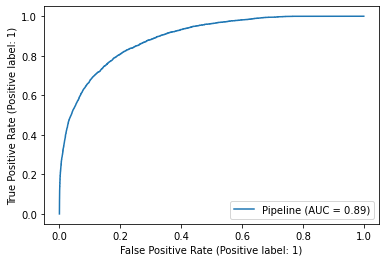

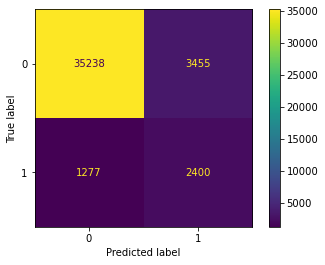

In [349]:
rf_pipe3.print_summary()

In [350]:
imb_pipe3.score(X_test,y_test)

0.8809119229679977

In [351]:
f1_score(y_test,imb_pipe3.predict(X_test))

0.46296296296296297

In [352]:
preds = imb_pipe3.predict_proba(X_test)[:,1]

In [353]:
roc_auc_score(y_test,preds)

0.871924653260289

This model was able to bring the train and test f1 scores closer to each other. This is important because I want my model to be robust against unseen data. The train and test split might have caused the disparity between the f1 scores but I'm glad that my model was giiven a bad split so I could adjust the model to adapt to that.